**PODDeepONet using DeepXDE module**

In [1]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Data loading

In [2]:
datastore = h5py.File("C:/Users/arnab/OneDrive/Desktop/Study material/summer 24/Research/New equations/datasets/trials_many_alldata_new_eqution2.h5", 'r')
data_I = np.array(np.array(datastore["I"]))

data_c = np.array(np.array(datastore["c"]))
data_h = np.array(np.array(datastore["h"]))
t = np.linspace(0, 1, 601).reshape(601, 1)

Train-test split

In [3]:
train_label, test_label = train_test_split(range(len(data_I)), test_size=0.25, random_state=42)

data_i_train = data_I[train_label,:]
data_i_test = data_I[test_label,:]

data_c_train = data_c[train_label,:]
data_c_test = data_c[test_label,:]

data_h_train = data_h[train_label,:]
data_h_test = data_h[test_label,:]

In [4]:
X_train = (data_i_train.astype(np.float32), t.astype(np.float32))
y_train_c = data_c_train.astype(np.float32)

In [5]:
X_test = (data_i_test.astype(np.float32), t.astype(np.float32))
y_test_c = data_c_test.astype(np.float32)

**Finding POD Basis**

In [6]:
def compute_pod(G, k=None, energy_threshold=0.99):
    """
    Compute the Proper Orthogonal Decomposition (POD) of a dataset.
    
    Parameters:
        G (numpy.ndarray): A matrix of shape (n_points, n_samples), 
                           where each column is a discretized function.
        energy_threshold (float): Fraction of total energy to capture (default: 99%).

    Returns:
        phi (numpy.ndarray): POD modes (basis functions) of shape (n_points, k).
        singular_values (numpy.ndarray): Singular values of G.
        energy_captured (list): Cumulative energy captured for each mode.
        k (int): Number of modes required to meet the energy threshold.
    """
    # Step 1: Perform Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(G, full_matrices=False)
    # U: Left singular vectors (POD modes)
    # S: Singular values
    # Vt: Right singular vectors (transpose of eigenvectors of GG^T)
    
    # Step 2: Compute the total energy (sum of squared singular values)
    total_energy = np.sum(S**2)
    
    # Step 3: Compute the cumulative energy captured by each mode
    energy_captured = np.cumsum(S**2) / total_energy

    # Step 4: Determine the number of modes required to meet the energy threshold
    k = np.argmax(energy_captured >= energy_threshold) + 1  # First mode where energy exceeds threshold
    
    # Step 5: Return the POD modes and the number of modes
    phi = U[:, :k]  # Truncate U to get the first k modes
    return phi, S, energy_captured, k


In [21]:
y_train_c_mean = np.mean(y_train_c, axis=1)
y_train_c_centered = y_train_c - y_train_c_mean[:, np.newaxis]

In [25]:
# Compute POD
phi, singular_values, energy_captured, k = compute_pod(y_train_c_centered.T, energy_threshold=0.99)

# Print results
print(f"Number of POD modes to capture 99% energy: {k}")
print(f"Singular values: {singular_values[:k]}")
print(f"Energy captured by each mode: {energy_captured[:k]}")
print(phi.shape)

Number of POD modes to capture 99% energy: 7
Singular values: [8442.003   4442.153   2384.9465  1590.6075  1100.9906   788.7572
  605.08673]
Energy captured by each mode: [0.6981063  0.8913999  0.9471169  0.97190005 0.9837741  0.9898683
 0.99345475]
(601, 7)


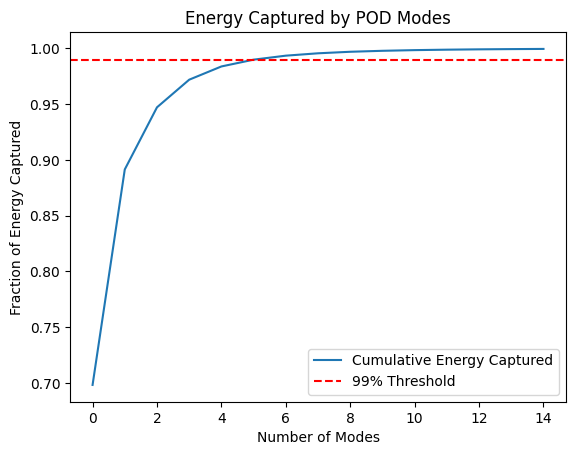

In [27]:
# Plot the cumulative energy
plt.plot(energy_captured[:15], label="Cumulative Energy Captured")
plt.axhline(0.99, color="red", linestyle="--", label="99% Threshold")
plt.xlabel("Number of Modes")
plt.ylabel("Fraction of Energy Captured")
plt.title("Energy Captured by POD Modes")
plt.legend()
plt.show()


**Making the data compatible with deepxde.nn.pytorch.deeponet.PODDeepONet**

In [28]:
data_c = dde.data.TripleCartesianProd(
    X_train=X_train, y_train=y_train_c, X_test=X_test, y_test=y_test_c
)

**Defining the PODDeepONet model**

In [38]:
m = 601
dim_x = 1
net = dde.nn.PODDeepONet(
    pod_basis = phi,
    layer_sizes_branch = [m, 300, 200, 100, k],
    activation = "relu",
    kernel_initializer = "Glorot normal",
    # layer_sizes_trunk = [dim_x, 200, 200, 8],
)

**Counting the number of learnable parameters in the model**

In [37]:
def compute_parameters(layers):
    params = 0
    for i in range(len(layers) - 1):
        params += layers[i] * layers[i + 1]  # Weights
        params += layers[i + 1]             # Biases
    return params

branch_layers = [m, 300, 200, 100, 8]

branch_params = compute_parameters(branch_layers)
total_params = branch_params
print(f"Total trainable parameters: {total_params}")


Total trainable parameters: 261708


**Training the model**

In [39]:
model_c = dde.Model(data_c, net)
# lr = ReduceLROnPlateau(optimizer_combined, mode='min', factor=0.5, patience=5)
model_c.compile("adam", lr=0.01)
# print(model_c.predict((data_i_test[0].reshape(1, -1), t)).shape)
losshistory_c, train_state_c = model_c.train(iterations=1000, display_every=100)

Compiling model...
'compile' took 0.000233 s

Training model...

0         [1.83e+01]    [1.81e+01]    []  
100       [1.66e+01]    [1.65e+01]    []  
200       [1.64e+01]    [1.63e+01]    []  
300       [1.64e+01]    [1.63e+01]    []  
400       [1.63e+01]    [1.62e+01]    []  
500       [1.63e+01]    [1.62e+01]    []  
600       [1.63e+01]    [1.62e+01]    []  
700       [1.63e+01]    [1.62e+01]    []  
800       [1.63e+01]    [1.62e+01]    []  


KeyboardInterrupt: 